In [2]:
import torch
from torch import utils
import pandas as pd
import numpy as np
from pathlib import Path 
from matplotlib import pyplot as plt
from deep_cluster.dataloader import *
pd.set_option('mode.chained_assignment', None)

import os
import re
import numpy as np
import scipy.signal as sig
import pandas as pd

# root directory of data
data_root = Path("/home/orel/Storage/Data/K6/")
landmark_files = []
for subdir in os.listdir(data_root):
    for file in os.listdir(data_root/subdir/'Down'):
        if re.match(r"00\d*DeepCut_resnet50_Down2May25shuffle1_1030000\.h5", file):
            lfile = data_root/subdir/'Down'/file
            landmark_files.append(lfile)


## TODO:  
Try using square root to normalize the wavelets, see hoe it affects  kurtosis and histogram.

In [3]:
def calc_wavelet_transform(feature_data, min_width=12, max_width=120, n_waves=25):
    wavelet_widths = np.logspace(np.log10(min_width), np.log10(max_width), n_waves)
    transformed = sig.cwt(feature_data, sig.morlet2, widths=wavelet_widths)
    transformed /= wavelet_widths[:,np.newaxis]
    return np.abs(transformed)

# A dataset of landmarks
# args: landmarks file: .h5 file of landmarks, from DeepLabCut
class LandmarkWaveletDataset(utils.data.Dataset):
    def __init__(self, landmarks_file, normalize=True, data=None, eps=3e-2):
        super(LandmarkWaveletDataset, self).__init__()
        self.file = landmarks_file
        self.normalize = normalize
        self.landmarks = LandmarkDataset(self.file, normalize)
        if data is None:
            coords = sig.decimate(self.landmarks.coords, q=4, axis=0)
            coords = coords.reshape((len(coords), -1))
            self.data = [calc_wavelet_transform(feat_data, min_width=2, max_width=30, n_waves=20) for feat_data in coords.T]
            self.data = np.concatenate(self.data, axis=0).T
            self.data = np.log(self.data + eps) + 2
        else:
            self.data = data
        
    def __getitem__(self, idx):
        if isinstance(idx, slice):
            return LandmarkWaveletDataset(self.file, self.normalize, data=self.data[idx])
        return self.data[idx]
    
    def __len__(self):
        return self.data.shape[0]


In [4]:
for i, f in list(enumerate(landmark_files)):
    print(i, f)
    ds = LandmarkWaveletDataset(f)

0 /home/orel/Storage/Data/K6/2020-03-26/Down/0011DeepCut_resnet50_Down2May25shuffle1_1030000.h5
1 /home/orel/Storage/Data/K6/2020-03-22/Down/0007DeepCut_resnet50_Down2May25shuffle1_1030000.h5
2 /home/orel/Storage/Data/K6/2020-03-18/Down/0003DeepCut_resnet50_Down2May25shuffle1_1030000.h5
3 /home/orel/Storage/Data/K6/2020-03-31/Down/0015DeepCut_resnet50_Down2May25shuffle1_1030000.h5
4 /home/orel/Storage/Data/K6/2020-03-24/Down/0009DeepCut_resnet50_Down2May25shuffle1_1030000.h5
5 /home/orel/Storage/Data/K6/2020-03-25/Down/0010DeepCut_resnet50_Down2May25shuffle1_1030000.h5
6 /home/orel/Storage/Data/K6/2020-03-19/Down/0004DeepCut_resnet50_Down2May25shuffle1_1030000.h5
8 /home/orel/Storage/Data/K6/2020-03-29/Down/0013DeepCut_resnet50_Down2May25shuffle1_1030000.h5
9 /home/orel/Storage/Data/K6/2020-03-30/Down/0014DeepCut_resnet50_Down2May25shuffle1_1030000.h5
10 /home/orel/Storage/Data/K6/2020-03-27/Down/0012DeepCut_resnet50_Down2May25shuffle1_1030000.h5
11 /home/orel/Storage/Data/K6/2020-04-0

In [ ]:
for i, f in list(enumerate(landmark_files))[::-1]:
    print(i, f)
    ds = LandmarkWaveletDataset(f)

In [6]:
ds = LandmarkWaveletDataset(landmark_files[8])
dsets = [LandmarkWaveletDataset(f) for f in landmark_files[:5]]

In [11]:
np.prod(dsets[0].data.shape) * 4 * 12

2856107520

In [1]:
ds1 = utils.data.ConcatDataset([ds[:1000], ds[10000:11000]])

NameError: name 'utils' is not defined

In [96]:
ds.data[ds.data > ds.data.min() + 1e-3].mean()

-1.8518811694883994

In [95]:
ds.data.min(), np.exp(3e-2)

(-3.506557897319982, 1.030454533953517)

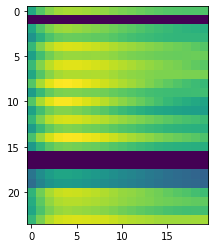

In [89]:
plt.imshow(ds.data.mean(axis=0).reshape(24, 20))

1.2135759579664385

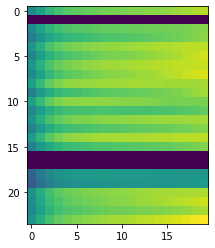

In [78]:
plt.imshow(ds.data.mean(axis=0).reshape(24, 20))
ds.data.std()

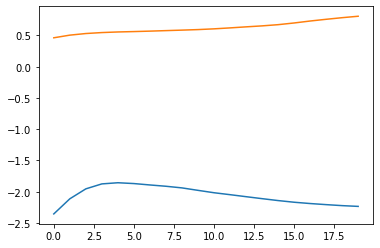

In [82]:
plt.plot(ds.data.mean(axis=0).reshape(24, 20).mean(axis=0))
plt.plot(ds.data.std(axis=0).reshape(24, 20).mean(axis=0))

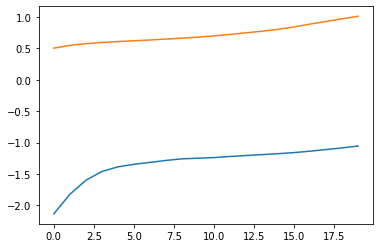

In [79]:
plt.plot(ds.data.mean(axis=0).reshape(24, 20).mean(axis=0))
plt.plot(ds.data.std(axis=0).reshape(24, 20).mean(axis=0))

1

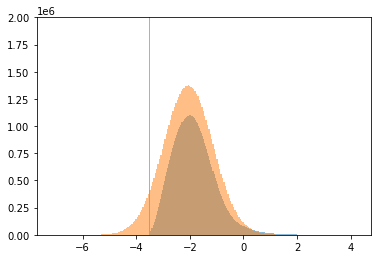

In [83]:
lg = False
plt.hist(ds.data.flatten(), bins=200, log=lg, alpha=0.5)
# plt.hist(np.random.laplace(loc=data.mean(), scale=np.abs(data-data.mean()).mean(), size=len(data.flatten())), log=lg, alpha=0.5, bins=200)
plt.hist(np.random.normal(loc=ds.data.mean(), scale=ds.data.std(), size=len(ds.data.flatten())), log=lg, alpha=0.5, bins=200)
plt.ylim((0, 2e6))
1

1

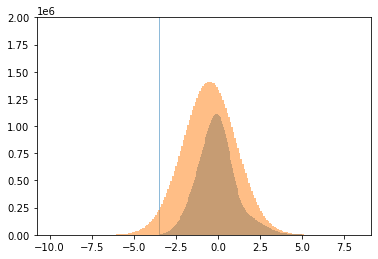

In [69]:
lg = False
plt.hist(ds.data.flatten(), bins=200, log=lg, alpha=0.5)
# plt.hist(np.random.laplace(loc=data.mean(), scale=np.abs(data-data.mean()).mean(), size=len(data.flatten())), log=lg, alpha=0.5, bins=200)
plt.hist(np.random.normal(loc=ds.data.mean(), scale=ds.data.std(), size=len(ds.data.flatten())), log=lg, alpha=0.5, bins=200)
plt.ylim((0, 2e6))
1

In [29]:
data.mean()

-1.7774274779722163e-08

1

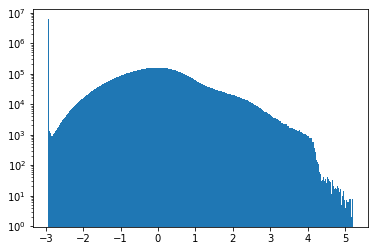

In [39]:
plt.hist(ds.data.flatten(), bins=1000, log=True)
1

(-2.364163833753029, 1.211087216369255)

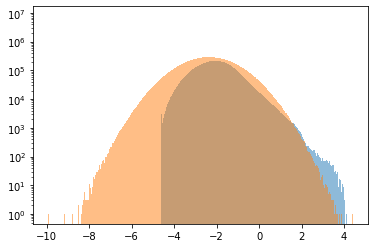

In [57]:
eps = 1e-2
log_data = np.log(ds.data[ds.data>-eps].flatten() + eps)
plt.hist(log_data, bins=1000, log=True, alpha=0.5)
plt.hist(np.random.normal(loc=log_data.mean(), scale=log_data.std(), size=len(log_data)), bins=1000, log=True, alpha=0.5)
log_data.mean(), log_data.std()

In [ ]:
log_data.min()

In [147]:
np.log(ds.data[ds.data>eps].flatten() + eps).mean(), np.log(ds.data[ds.data>eps].flatten() + eps).std()

(-0.05576794733710523, 1.2547144081463357)

1

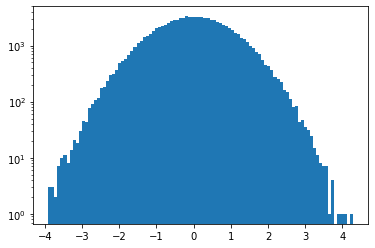

In [134]:
plt.hist(np.random.normal(size=100000), bins=100, log=True)
1

In [2]:
data_path = Path('/home/orel/Data/K6/2020-03-30/Down/')
landmarks_file = data_path / '0014DeepCut_resnet50_DownMay7shuffle1_1030000.h5'

In [3]:
def extract_coords(landmarks_file):
    df = read_df(landmarks_file)
    return pd.unique([col[0] for col in df.columns])


extract_coords(landmarks_file)

array(['nose', 'neck', 'forepawR', 'forePawL', 'chest', 'belly',
       'hindpawR', 'hindpawL', 'tailbase', 'tail1', 'tail2', 'tail3'],
      dtype=object)

In [10]:
extract_coords(landmark_files[2])

array(['nose', 'neck', 'forepawR', 'forePawL', 'chest', 'belly',
       'hindpawR', 'hindpawL', 'tailbase', 'tail1', 'tail2', 'tail3'],
      dtype=object)